# Glidertest demo 


The purpose of this notebook is to demostrate the functionality of glidertests functions. 
This notebooks can be used to diagnose issues within your glider data. We have added suggested processing in some cases.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from glidertest import fetchers
from glidertest import tools

### Load dataset

Load an example dataset using `glidertest.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

In [ ]:
ds = fetchers.load_sample_dataset()

In [3]:
ds

<xarray.Dataset>
Dimensions:                 (N_MEASUREMENTS: 2446)
Coordinates:
    dive_num                (N_MEASUREMENTS) float64 ...
    LONGITUDE               (N_MEASUREMENTS) float64 ...
    LATITUDE                (N_MEASUREMENTS) float64 ...
    TIME                    (N_MEASUREMENTS) datetime64[ns] ...
    DEPTH                   (N_MEASUREMENTS) float64 ...
Dimensions without coordinates: N_MEASUREMENTS
Data variables: (12/20)
    POTDENS0                (N_MEASUREMENTS) float64 ...
    HEADING                 (N_MEASUREMENTS) float64 ...
    ROLL                    (N_MEASUREMENTS) float64 ...
    PITCH                   (N_MEASUREMENTS) float64 ...
    GLIDER_VERT_VELO_MODEL  (N_MEASUREMENTS) float64 ...
    GLIDE_ANGLE             (N_MEASUREMENTS) float64 ...
    ...                      ...
    TEMP                    (N_MEASUREMENTS) float64 ...
    dive_num_cast           (N_MEASUREMENTS) float64 ...
    PROFILE_NUMBER          (N_MEASUREMENTS) float64 ...
    PHASE                   (N_MEASUREMENTS) float64 ...
    PHASE_QC                (N_MEASUREMENTS) int64 ...
    DEPTH_Z                 (N_MEASUREMENTS) float64 ...
Attributes: (12/44)
    title:                                      OceanGliders trajectory file
    platform:                                   sub-surface gliders
    platform_vocabulary:                        https://vocab.nerc.ac.uk/coll...
    id:                                         SG015_20050213T230253_delayed
    naming_authority:                           edu.washington.apl
    institution:                                School of Oceanography\nUnive...
    ...                                         ...
    contributing_institutions_vocabulary:       https://edmo.seadatanet.org/r...
    contributing_institutions_role:             Operator, Data scientist
    contributing_institutions_role_vocabulary:  http://vocab.nerc.ac.uk/colle...
    uri_comment:                                UUID
    landstation_version:                        3707.7999999523163
    glider_firmware_version:                    66.05

### Vertical velocity

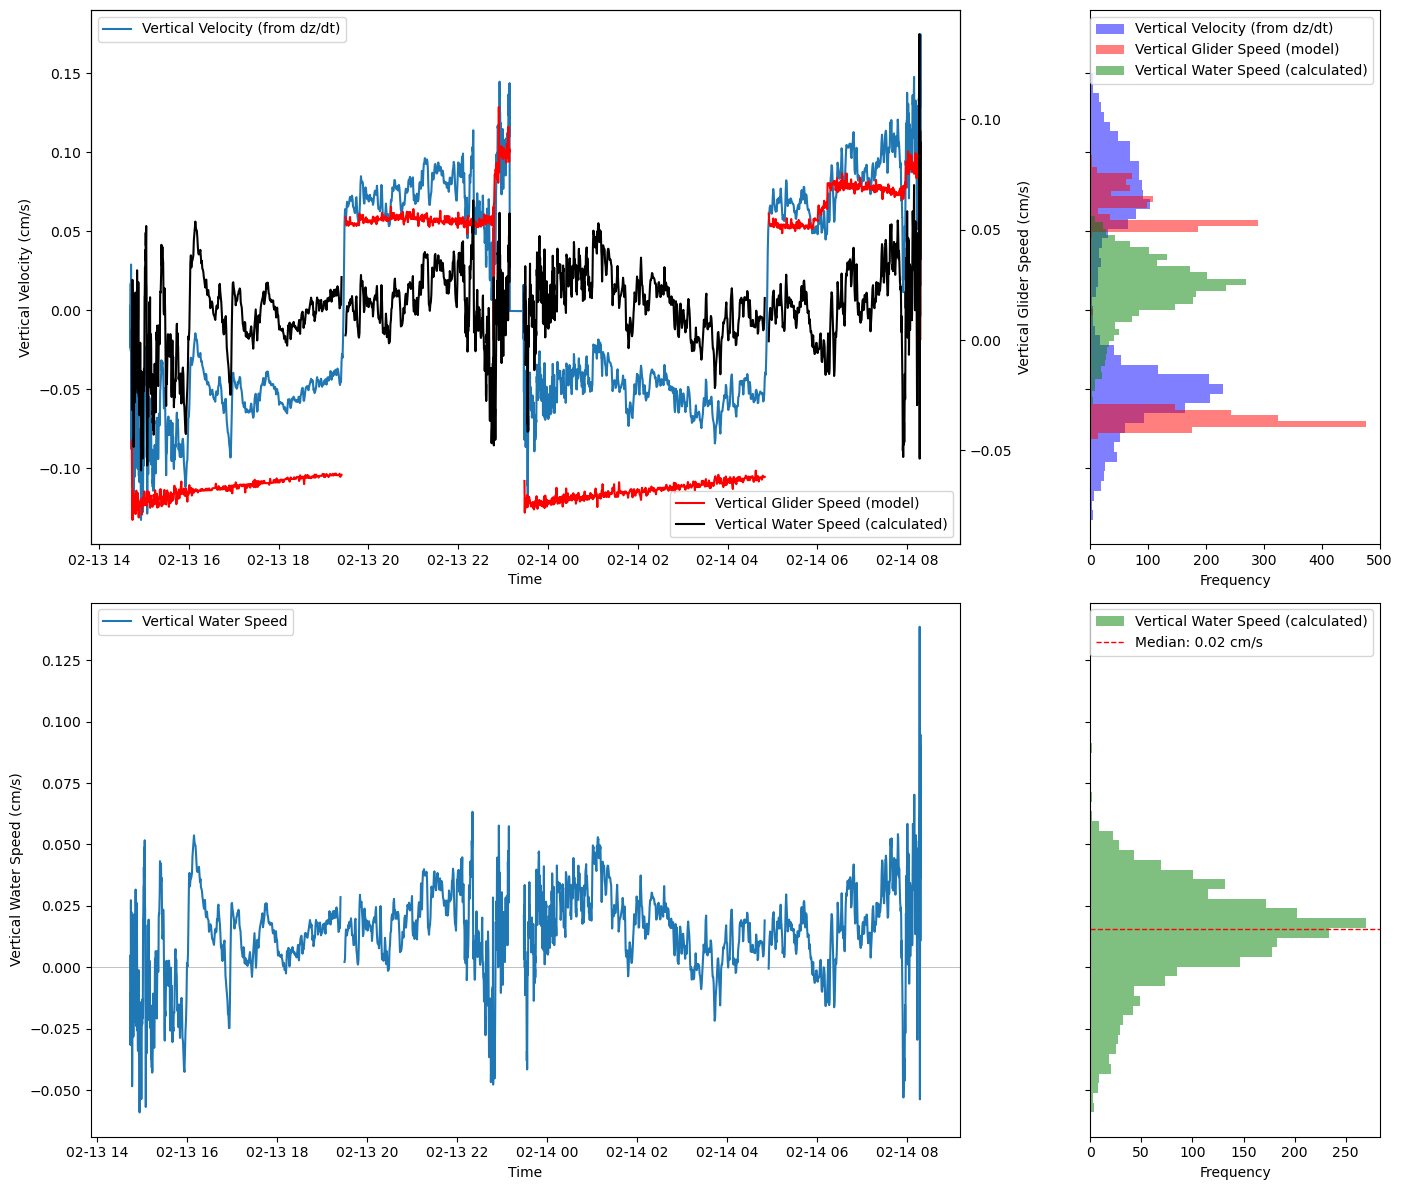

(<Figure size 1400x1200 with 5 Axes>,
 array([[<Axes: xlabel='Time', ylabel='Vertical Velocity (cm/s)'>,
         <Axes: xlabel='Frequency'>],
        [<Axes: xlabel='Time', ylabel='Vertical Water Speed (cm/s)'>,
         <Axes: xlabel='Frequency'>]], dtype=object))

In [ ]:
# Calculate vertical seawater velocity 
# First, calculate the vertical speed of the glider from the depth data
ds = tools.calc_glider_w_from_depth(ds)

# Next, calculate the vertical seawater speed by differencing the DZDT data and the modelled vertical glider speed
ds = tools.calc_seawater_w(ds)

tools.plot_vertical_speeds_with_histograms(ds)



# Basic statistics of dataset

/Users/eddifying/Cloudfree/gitlab-cloudfree/glidertest/glidertest/tools.py:655: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([pd.to_datetime(t).strftime('%Y-%b-%d') for t in cbar.get_ticks()])


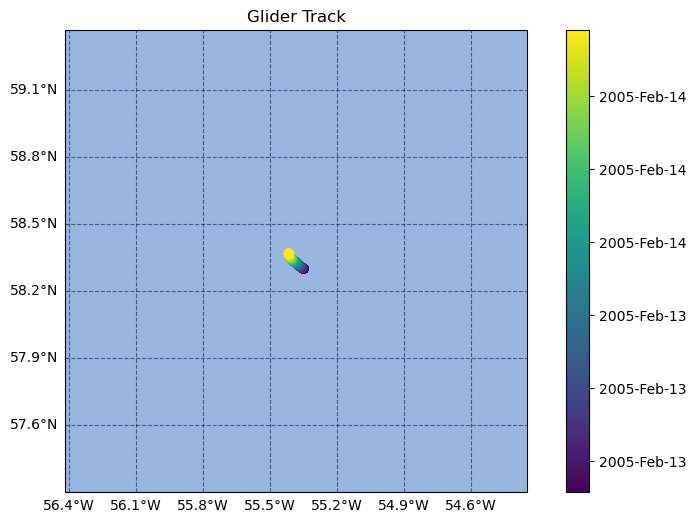

(<Figure size 1000x600 with 2 Axes>,
 <GeoAxes: title={'center': 'Glider Track'}, xlabel='Longitude', ylabel='Latitude'>)

In [5]:
# Basic plot of the location of the dataset in space/time
tools.plot_glider_track(ds)

(<Figure size 1400x600 with 2 Axes>,
 array([<Axes: title={'center': 'Histogram of Depth Spacing'}, xlabel='Depth Spacing (m)', ylabel='Frequency'>,
        <Axes: title={'center': 'Histogram of Time Spacing'}, xlabel='Time Spacing (s)', ylabel='Frequency'>],
       dtype=object))

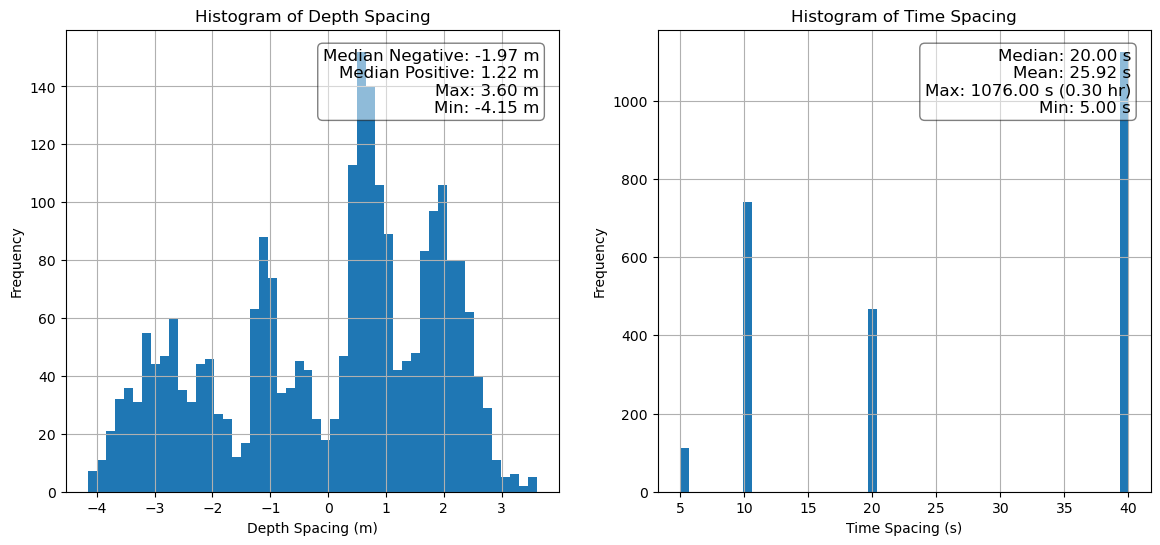

In [6]:
# Basic diagnostics of the gridding in the dataset
tools.plot_grid_spacing_histograms(ds)

(<Figure size 1800x600 with 4 Axes>,
 array([<Axes: title={'center': 'Histogram of Temperature'}, xlabel='Conservative Temperature (°C)', ylabel='Frequency'>,
        <Axes: title={'center': 'Histogram of Salinity'}, xlabel='Absolute Salinity ( )', ylabel='Frequency'>,
        <Axes: title={'center': '2D Histogram of Salinity and Temperature (Log Scale)'}, xlabel='Absolute Salinity ( )', ylabel='Conservative Temperature (°C)'>],
       dtype=object))

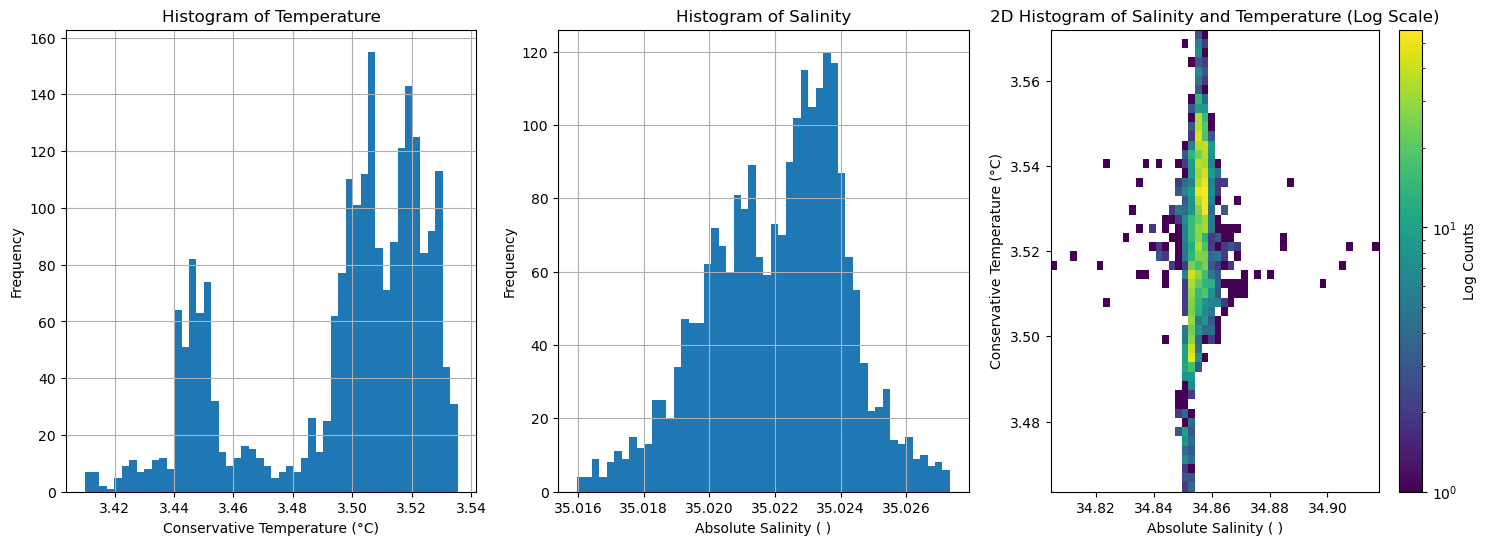

In [ ]:
# Basic diagnostics of the watermass properties
tools.plot_ts_histograms(ds)


### Check basic data and water column structure first

In [ ]:
tools.plot_basic_vars(ds,v_res=1, start_prof=1, end_prof=int(ds.PROFILE_NUMBER.max()))

## Check if the profile number was assigned well 

We want to check if the profile number is consistently increasing or not.
When using pyglider to assign the profile, there can be some issues if the correct pressure and time threshold is not chosen.

Users, based on their dataset will chose a specific min_dp and profile_min_time for the get_profiles_new(). If not chosen carefully, the function may struggle assigning a profile number (resulting in 0s in the middle of the dataset) or could split profiles when, for example, the glider get stuck on pycnoclne


In [ ]:
tools.check_monotony(ds.PROFILE_NUMBER)
tools.plot_profIncrease(ds)

### Check for up-downcast bias in Salinity, Temperature, Chlorophyll and Oxygen

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

tools.plot_updown_bias(tools.updown_bias(ds, var='TEMP', v_res=1), ax[0],  xlabel='Temperature [C]')
tools.plot_updown_bias(tools.updown_bias(ds, var='PSAL', v_res=1), ax[1],  xlabel='Salinity [PSU]')
tools.plot_updown_bias(tools.updown_bias(ds, var='DOXY', v_res=1), ax[2],  xlabel='Dissolved Oxygen [mmol m-3]')
tools.plot_updown_bias(tools.updown_bias(ds, var='CHLA', v_res=1), ax[3],  xlabel='Chlorophyll [mg m-3]')


ax[0].set_ylabel('Depth [m]')

### CTD

Check for any thermal intertia related issues

Salinity SOP provides a great summary of the needed processing of salinity data and the vaious difference based on sensor modela nd platform type https://oceangliderscommunity.github.io/Salinity_SOP/sections/salinity_dmqc.html

### Chlorophyll fluorescence

*  Check bottom data and see if we have stable data that can be used for calibration. We also check stability of data to assess whether or not we have suspicious drift over the mission
* We check for any temporal drift when analysing the entire water column and not just the bottom data
* We then check if data is affected by non photochemical quenching (NPQ). NPQ is a physiological response to high light environments used by plants and algae to protect themselves from damage and causes an evident weakening in fluorescence signal during the day. With the 'day_night_avg' function, we compute day and night averages of chlorophyll. We then plot a selected section of chlorophyll data with 'plot_section_with_srss' to see if any NPQ effect in the top few meters is visible and then we plot a selcted day daily and night average to check again any NPQ effect with 'plot_daynight_avg'.

(Reminder this tests mission had issues with FLBBCD as it stopped working few days into the missiona and got flooded)

In [ ]:
tools.optics_first_check(ds, var='CHLA')

In [ ]:
tools.check_temporal_drift(ds, var='CHLA')

In [ ]:
# Let's visually check a section of chlorphyll and see if we observe any NPQ
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

tools.plot_section_with_srss(ds, 'CHLA', ax, start_time = '2023-06-04', end_time = '2023-06-06', ylim=35)

In [ ]:
# Compute day and night average for chlorophylla and temeparture
dayT, nightT = tools.day_night_avg(ds, sel_var='TEMP',start_time = '2023-06-03', end_time = '2023-06-07')
dayS, nightS = tools.day_night_avg(ds, sel_var='PSAL',start_time = '2023-06-03', end_time = '2023-06-07')
dayC, nightC = tools.day_night_avg(ds, sel_var='CHLA',start_time = '2023-06-03', end_time = '2023-06-07')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

tools.plot_daynight_avg( dayT, nightT, ax[0],sel_day='2023-06-04', xlabel='Temperature [C]')
tools.plot_daynight_avg( dayS, nightS, ax[1],sel_day='2023-06-04', xlabel='Salinity [PSU]')
tools.plot_daynight_avg( dayC, nightC, ax[2],sel_day='2023-06-04', xlabel='Chlorophyll [mg m-3]')

Do we see any difference in chl between day and night? Can this just simply be explained by changes in water mass properties (different temp and salinity)?

#### Non photochemical quenching corrections
NPQ occurs only during the daytime, therefore when night measurements close in time and 
space are available, they can be used to correct daytime profiles. Different methods exist for NPQ 
correction. We recommend the paper by Thomalla et al. (2018) for a good overview on all possible methods. 
GliderTools (https://glidertools.readthedocs.io/en/latest/optics.html#quenching-correction) provides good tools for correction

Thomalla, S. J., W. Moutier, T. J. Ryan-Keogh, L. Gregor, and J. Schütt. 2018. An optimized 
method for correcting fluorescence quenching using optical backscattering on autonomous 
platforms. Limnology and Oceanography: Methods, 16: 132-144. DOI: 
https://doi.org/10.1002/lom3.10234

### Photosyntetically Active Radiation (PAR)

In [ ]:
ds_par = fetchers.load_sample_dataset(dataset_name="sea055_20220104T1536_delayed.nc")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
tools.plot_updown_bias(tools.updown_bias(ds_par, var='DPAR', v_res=1), ax,  xlabel='Irradiance')

Do we notice any strong up down cast bias?

Likely we do as the diving angle changes. The pitch for upcast and downcast are very different while the position of the sensor remains the same. This means that the angle at which the sensor is exposed to light is very different and data will not be comparable. Furthermore, navigation patterns have to be considered too when processing PAR data. As the glider sits at surface, the pitch (therefore the sensor angle) can be very different from the rest of the dive. Moreover, as the glider starts to dive or prepares for surfacing during a climb the pitch may be very different as well.

Discarding and reconstructing algebraically the surface PAR using an exponential equation and selecting data from only up or downcast is therefore recommended. GliderTools provides great examples and functions to address this issues (https://glidertools.readthedocs.io/en/latest/optics.html#par-replacement)

### Optical Backscatter

*  Check bottom data and see if we have stable data that can be used for calibration. We also check stability of data to assess whether or not we have suspicious drift over the mission
* We check for any temporal drift when analysing the entire water column and not just the bottom data
* In case computation of particle backscattering from the scaled optical data was not done, this can be done following a function from GliderTools. this functions uses uses the coefficients from Zhang et al. (2009) to convert the raw counts into total backscatter (m-1), correcting for temperature and salinity. The $\chi$ factor and $\theta$ in this example were taken from Sullivan et al. (2013) and Slade & Boss (2015).

Slade, W., Boss, E. 2015. Spectral attenuation and backscattering as indicators of average particle size. Applied Optics 54: 7264-7277, doi:10.1364/AO.54.00726. 

Sullivan, J., Twardowski, M., Zaneveld, J.R.V., Moore, C. 2013. Measuring optical backscattering in water. Light Scattering Reviews 7. 189-224. 10.1007/978-3-642-21907-8_6.

Zhang, X., and L. Hu. 2009. Estimating scattering of pure water from density fluctuation of the 
refractive index. Optics Express, 17: 1671-1678. DOI: 10.1364/OE.17.001671 7

In [ ]:
tools.optics_first_check(ds, var='BBP700')

In [ ]:
tools.check_temporal_drift(ds, var='BBP700')

### Oxygen

*  Check for any possible drift in the data that might look suspicious. The great temporal and spatial variability may not allow for such check to be succesful. Evaluation using reference CTD cast data or any other data available in the stufy area is recommended.

Oxygen SOP provides a great summary of the needed processing of salinity data and the vaious difference based on sensor model and platform type https://oceangliderscommunity.github.io/Salinity_SOP/sections/salinity_dmqc.html

In [ ]:
tools.check_temporal_drift(ds, var='DOXY')